In [1]:
import csv
import time
from decimal import Decimal
from utils.IBRS import TRC, RSU, OBU
from utils.drawtools import pltbar, pltpoly
from random import choice

In [2]:
# N = 10000 # 实验次数，最后结果取平均
N = 1 # debug mode
types = [[] for i in range(8) ]
time_cost = [[] for i in range(8)]

In [3]:
with open('./data/VID.csv') as f: # 导入 VID 池
    csv_reader = csv.reader(f)
    head = next(csv_reader)
    VID_POOL = [x for x in csv_reader]

In [4]:
def basic_test(types, time_cost, test_domain, test_func):
    for i, t in enumerate(types):
        for j in test_domain:
            result = test_func(N, j, t)
            time_cost[i].append(float(result))

---

## [Round1 - OBU Generation] SS512 vs MNT159


In [5]:
def test_obugen(N, L, t_trc):
    recorder = []
    trc = TRC(t_trc, L, 'exp #1')
    start = time.process_time()
    for i in range(N):
        obu = OBU(trc, VID_POOL[i])
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost

横坐标： 二叉树的深度，`range(10, 19)`

纵坐标： 时间，单位：毫秒 （精确到小数点后两位）

比较对象： SS512, MNT159

---

In [6]:
types[0] = ['MNT159', 'SS512']
time_cost[0] = [[], []]
basic_test(types[0], time_cost[0], range(10, 18), test_obugen)

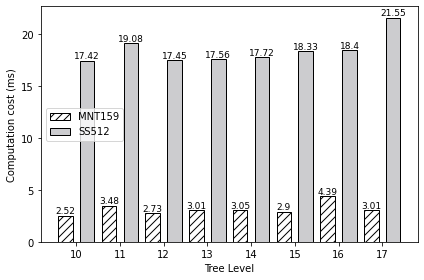

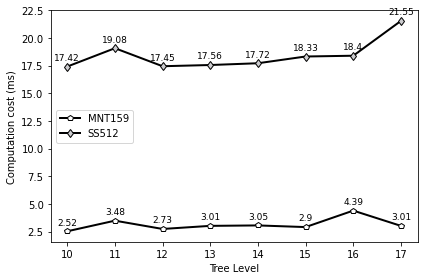

In [7]:
pltbar(len(time_cost[0][0]), 12, time_cost[0], types[0], range(10, 18), 'Computation cost (ms)', 6, 'Tree Level', 'obu_bar')
pltpoly(len(time_cost[0][0]), time_cost[0], types[0], range(10, 18), 'Computation cost (ms)', 6, 'Tree Level', 'obu_poly')

---

## [Round2 - V2I, I2V] SS512 vs MNT159

#### [Round2 - V2I]

横坐标： 二叉树的深度，range(10, 19)

纵坐标： 时间，单位：毫秒 （精确到小数点后两位）

比较对象： SS512, MNT159

In [8]:
def test_v2i(N, L, t_trc):
    recorder = []
    trc = TRC(t_trc, L, 'exp #2-1')
    obu = OBU(trc, choice(VID_POOL))
    rsu = RSU(trc, 'rsu #1')
    start = time.process_time()
    for i in range(N):
        obu.v2i(rsu.pk)        
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost

In [9]:
types[1] = ['MNT159', 'SS512']
time_cost[1] = [[], []]
basic_test(types[1], time_cost[1], range(10, 19), test_v2i)

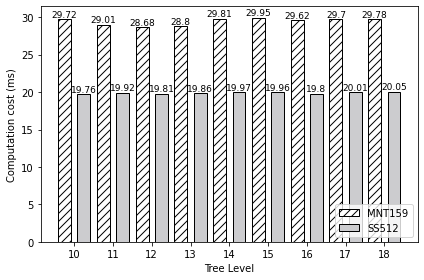

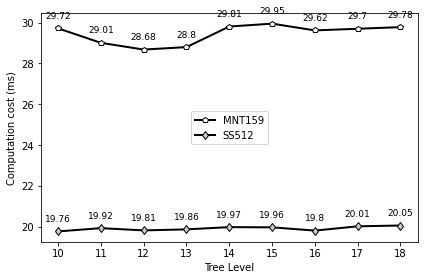

In [10]:
pltbar(len(time_cost[1][0]), 12, time_cost[1], types[1], range(10, 19), 'Computation cost (ms)', 4, 'Tree Level', 'V2I_bar')
pltpoly(len(time_cost[1][0]), time_cost[1], types[1], range(10, 19), 'Computation cost (ms)', 10, 'Tree Level', 'V2I_poly')

#### [Round2 - I2V]

横坐标： ring list 长度

纵坐标： 时间，单位： 毫秒 （精确到小数点后两位）

比较对象： SS512, MNT159

*默认二叉树的深度为 10*

In [11]:
def test_i2v(N, Ln, t_trc):
    recorder = []
    trc = TRC(t_trc, 10, 'exp #2-2')
    rsu = RSU(trc, 'rsu #1')
    ct = []
    for i in range(Ln):
        obu = OBU(trc, VID_POOL[i])
        ct.append(obu.v2i(rsu.pk))
    start = time.process_time()
    rsu.i2v(ct, trc.kunodes())
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost

In [12]:
types[2] = ['MNT159', 'SS512']
time_cost[2] = [[], []]
basic_test(types[2], time_cost[2], range(2, 13), test_v2i)

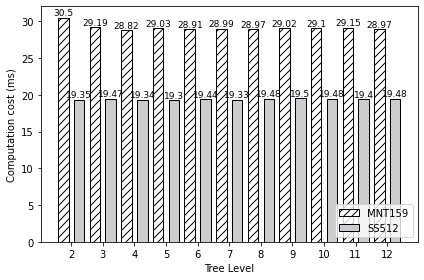

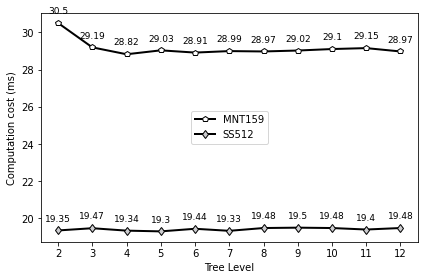

In [13]:
pltbar(len(time_cost[2][0]), 12, time_cost[2], types[2], range(2, 13), 'Computation cost (ms)', 4, 'Tree Level', 'I2V_bar')
pltpoly(len(time_cost[2][0]), time_cost[2], types[2], range(2, 13), 'Computation cost (ms)', 10, 'Tree Level', 'I2V_poly')

---

## [Round3 - Revocation] Straightforward vs Kunodes algorithm

横坐标： 撤销的车辆数目， `range(10, 1001, 20)`

纵坐标： 生成的撤销列表长度

*默认二叉树的深度为 10*

In [14]:
def test_revo(N, r_num, t_trc):
    recorder = []
    counter = []
    for k in range(N):        
        obus = []
        trc = TRC(t_trc, 10, 'exp #3')
        for i in range(1, 2 ** 10):
            temp_obu = OBU(trc, VID_POOL[i])
            obus.append(temp_obu)
        rl = []
        for i in range(1, r_num):
            temp = choice(obus)
            rl.append(temp)
            obus.remove(temp)
        trc.keyUp(rl)
        counter.append(len(trc.kunodes))
    return (r_num, sum(counter)/N)

In [15]:
types[3] = ['Straightforward', 'Kunodes']
time_cost[3] = [[], []]
for r in range(10, 1001, 100):
    result = test_revo(N, r, 'MNT159')
    time_cost[3][0].append(result[0])
    time_cost[3][1].append(result[1])

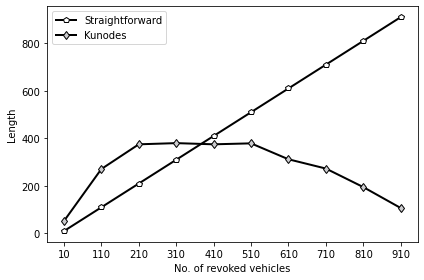

In [16]:
pltpoly(len(time_cost[3][0]), time_cost[3], types[3], range(10, 1001, 100), 'Length', 2, 'No. of revoked vehicles', 'revo_poly', show_num = False)

---

## [Round4 - Sign & Verify] SS512 vs MNT159

横坐标： ring 的长度

纵坐标： 时间，单位：毫秒 （精确到小数点后两位）

*默认二叉树的深度为10*

#### [Round4 - Sign]

In [17]:
def test_sign(N, r_num, t_trc):
    recorder = []
    trc = TRC(t_trc, 10, 'exp #4-1')
    rsu = RSU(trc, 'rsu #1')
    obus = [OBU(trc, VID_POOL[x]) for x in range(r_num)]
    ringList = [x.pk for x in obus]
    message = "TEST TEST TEST"
    start = time.process_time()
    for epoch in range(N):
        obu = choice(obus)
        obu.ring_sign(message, ringList)
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost

In [18]:
types[4] = ['MNT159', 'SS512']
time_cost[4] = [[], []]
basic_test(types[4], time_cost[4], range(2, 10), test_sign)

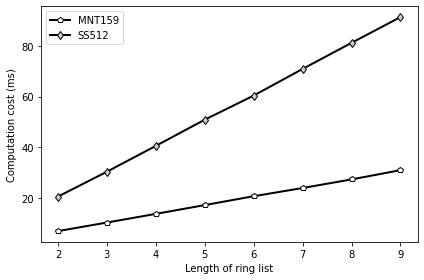

In [19]:
pltpoly(len(time_cost[4][0]), time_cost[4], types[4], range(2, 10), 'Computation cost (ms)', 2, 'Length of ring list', 'sign_poly', show_num = False)

#### [Round4 - Verify]

In [20]:
def test_veri(N, r_num, t_trc):
    recorder = []
    trc = TRC(t_trc, 10, 'exp #4-2')
    rsu = RSU(trc, 'rsu #1')
    obus = [OBU(trc, VID_POOL[x]) for x in range(r_num)]
    ringList = [x.pk for x in obus]
    message = "TEST TEST TEST"
    sigma = [obu.ring_sign(message, ringList) for obu in obus]
    start = time.process_time()
    for epoch in range(N):
        sig = choice(sigma)
        obu = choice(obus)
        obu.verify(sig, message, ringList)
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost   

In [21]:
types[5] = ['MNT159', 'SS512']
time_cost[5] = [[], []]
basic_test(types[5], time_cost[5], range(2, 10), test_veri)

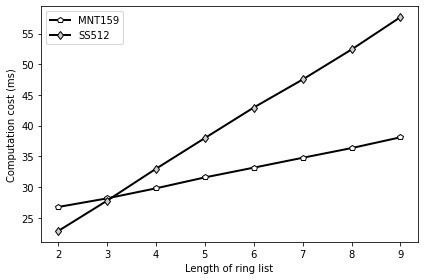

In [22]:
pltpoly(len(time_cost[5][0]), time_cost[5], types[5], range(2, 10), 'Computation cost (ms)', 2, 'Length of ring list', 'verify_poly', show_num = False)

#### [Round4 - Batch Verify]

横坐标： ring 的长度， range(10, 101, 10)

纵坐标： 平均时间，即验证一个签名所需的时间， 单位：毫秒 （精确到小数点后两位）

比较对象： batch mode off vs batch mode on

*默认二叉树深度为10. 签名个数为 100*

In [23]:
def test_batveri(N, s_num, r_num, flag = 1):
    trc = TRC('MNT159', 10, 'exp #4-3')
    obus = [OBU(trc, VID_POOL[x]) for x in range(1000)]
    sigmaList = []
    recorder = []
    for i in range(s_num):
        candidate = set()
        while len(candidate) < r_num:
            candidate.add(choice(obus))
        obu = choice(list(candidate))
        ringList = [x.pk for x in list(candidate)]
        message = 'TEST' + str(i)
        sigma = obu.ring_sign(message, ringList)
        sigmaList.append((sigma, message, ringList))
    
    start = time.process_time()
    for epoch in range(N):
        obu = choice(obus)
        obu.batchV(sigmaList)
    end = time.process_time()
    cost2 = Decimal((Decimal(end) - Decimal(start)) * 1000 / (N * s_num) ).quantize(Decimal("0.00"))
    
    if flag:
        start = time.process_time()
        for epoch in range(N):
            obu = choice(obus)
            for sigma in sigmaList:
                obu.verify(*sigma)
        end = time.process_time()
        cost1 = Decimal((Decimal(end) - Decimal(start)) * 1000 / (N * s_num) ).quantize(Decimal("0.00"))
        return (cost1, cost2)
    else:
        return cost2

In [24]:
types[6] = ['batch mode off', 'batch mode on']
time_cost[6] = [[], []]
for i in range(2, 10):
    ret = test_batveri(N, 10, i)
    time_cost[6][0].append(int(ret[0]))
    time_cost[6][1].append(int(ret[1]))

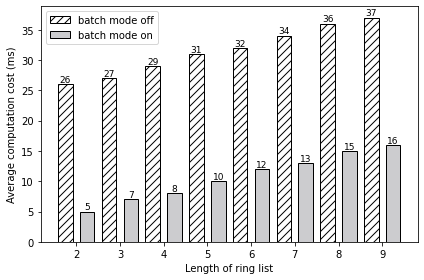

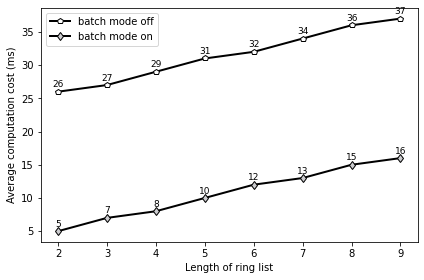

In [25]:
pltbar(len(time_cost[6][0]), 12, time_cost[6], types[6], range(2, 10), 'Average computation cost (ms)', 2, 'Length of ring list', 'batch_bar')
pltpoly(len(time_cost[6][0]), time_cost[6], types[6], range(2, 10), 'Average computation cost (ms)', 2, 'Length of ring list', 'batch_poly')

横坐标： 签名的数量， range(10, 101, 10)

纵坐标： 总时间， 单位：毫秒，（精确到小数点后两位）

比较对象： 不同的 ring list

In [27]:
types[7] = [2, 4, 6, 8]
time_cost[7] = [[], [], [], []]
for i, t in enumerate(types[7]):
    for j in range(10, 101, 10):
        ret = test_batveri(N, j, t, 0)
        time_cost[7][i].append(float(ret))

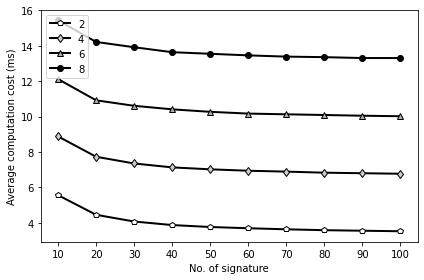

In [28]:
pltpoly(len(time_cost[7][0]), time_cost[7], types[7], range(10, 101, 10), 'Average computation cost (ms)', 2, 'No. of signature', 'batch2_poly', show_num=False)

---

## [Round5 - Communication TEST] Phase

> to be continue